# Analysis with Coffea

<h2>Authors</h2>
<b>Notebook by:</b> Mat Adamec (<i>UNL</i>)
<br/>
<br/>
<b>coffea:</b>
<br/>
<a href="https://doi.org/10.5281/zenodo.6335374"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.6335374.svg" alt="DOI"></a>
<br/>
    <ul>
        <li>Lindsey Gray, Matteo Cremonesi, Bo Jayatilaka, Oliver Gutsche, Nick Smith, Allison Hall, Kevin Pedro, Maria Acosta <i>(FNAL)</i>; Andrew Melo <i>(Vanderbilt)</i>; Stefano Belforte <i>(INFN)</i>; and others</li>
        <li>In collaboration with IRIS-HEP members: Jim Pivarski <i>(Princeton)</i>, Ben Galewsky <i>(NCSA)</i>, Mark Neubauer <i>(UIUC)</i></li>
        <br/>
    </ul>
<b><a href="https://github.com/CoffeaTeam/coffea-casa">coffea-casa</a>:</b>
    <ul>
        <li>Ken Bloom, Oksana Shadura <i>(UNL)</i>; Garhan Attebury, Carl Lundstedt, Derek Weitzel <i>(UNL-HCC)</i>; Mátyás Selmeci <i>(UWM)</i>; Brian Bockelman <i>(Morgridge Institute)</i></li>
    </ul>

## What is Coffea?

Coffea stands for *Columnar Object Framework For Effective Analysis.* It contains a variety of tools which help physicists perform their analyses in a columnar fashion. By "a columnar fashion," we mean that data is contained in numpy-like arrays upon which we can perform operations without calling an explicit event loop. Coffea is built on Awkward arrays and any Awkward operation can be done in a Coffea analysis. Beyond this, Coffea's analysis features can be broken into roughly four categories:

* **NanoEvents** turns data into an Awkward array wrapped with a schema. The schema serves a variety of purposes, from enabling us to interpret data as physics objects (e.g., LorentzVectors) to handling the nesting of our fields and creating relevant physical cross-references. In short: NanoEvents makes our data act nicely in the context of a physics analysis. A schema can be made for any ntuple file.

* **Hists** permit the plotting of ROOT-like histograms with Coffea.

* **Processors** are Coffea's way of encapsulating an analysis in a way that is deployment-neutral. Once you have a Coffea analysis, you can throw it into a processor and use any of a variety of executors (e.g. Dask, Parsl, Spark) to chunk it up and run it across distributed workers. This makes scale-out simple and dynamic on the user's end.

* **Lookup tools** are available in Coffea for any corrections that need to be made to physics data. These tools read a variety of correction file formats and turn them into lookup tables.

We will go through the first three points within this tutorial. As corrections tend to be experiment-specific, they are outside our scope, but the coffea docs offer some [examples](https://coffeateam.github.io/coffea/notebooks/applying_corrections.html) from a CMS perspective.

For the purposes of this tutorial we will be using a data sample converted to a generic ntuple format from a [Powheg+Pythia ttbar dataset](https://opendata.cern.ch/record/19981). It contains 40600 events at 1.3 GB.

## A Motivating Comparison

Placeholder. Showcase coffea vs. event loop to motivate why we'd want to use it.
* Find a suitable analysis for this.
* Maybe show the analysis we'll build through the tutorial, just to also show "where we'll end up?"
* If we do make a comparison here, then imports/NanoAODSchema warning messages will be here, so they remain here for now.

In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea import hist
import awkward as ak
import numpy as np
import uproot

## **Preliminary**: Data with Awkward

As mentioned in the overview, NanoEvents essentially bundles data with physical meaning. We input some ntuple file and we get an awkward array with some added utilities for physics. To follow a Coffea analysis, then, you need some familiarity with awkward. Awkward has a lot of great tutorials to refer to (including the one which preceded this talk), but this preliminary section is intended to show the necessary basics.

NanoEvents uses uproot to access data. The data is accessed lazily, so it is not instantiated until it is used. As our file is in an ntuple format, we can open it with the <code>BaseSchema</code> for now for the purposes of exploration. Later, we will use a schema to demonstrate the real power of NanoEvents.

In [2]:
events = NanoEventsFactory.from_root('https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root', schemaclass=BaseSchema, treepath='events').events()

What does our data look like? Well, it's an awkward array. Each entry in the awkward array corresponds to an event, and each event has various fields that stem from our data. It is a simple command to examine the fields:

In [3]:
events.fields

['numberelectron',
 'nelectron_e',
 'electron_e',
 'nelectron_pt',
 'electron_pt',
 'nelectron_px',
 'electron_px',
 'nelectron_py',
 'electron_py',
 'nelectron_pz',
 'electron_pz',
 'nelectron_eta',
 'electron_eta',
 'nelectron_phi',
 'electron_phi',
 'nelectron_ch',
 'electron_ch',
 'nelectron_iso',
 'electron_iso',
 'nelectron_isLoose',
 'electron_isLoose',
 'nelectron_isMedium',
 'electron_isMedium',
 'nelectron_isTight',
 'electron_isTight',
 'nelectron_dxy',
 'electron_dxy',
 'nelectron_dz',
 'electron_dz',
 'nelectron_dxyError',
 'electron_dxyError',
 'nelectron_dzError',
 'electron_dzError',
 'numGenPart',
 'nGenPart_pt',
 'GenPart_pt',
 'nGenPart_eta',
 'GenPart_eta',
 'nGenPart_mass',
 'GenPart_mass',
 'nGenPart_pdgId',
 'GenPart_pdgId',
 'nGenPart_phi',
 'GenPart_phi',
 'nGenPart_px',
 'GenPart_px',
 'nGenPart_py',
 'GenPart_py',
 'nGenPart_pz',
 'GenPart_pz',
 'nGenPart_status',
 'GenPart_status',
 'numberjet',
 'njet_e',
 'jet_e',
 'njet_pt',
 'jet_pt',
 'njet_px',
 'jet_p

It is also fairly simple (with Awkward) to check how many events we have:

In [4]:
ak.size(events, axis=0)

43962

Of course, each field of an event might have a variable amount of objects within it. We might have 0, 1, 2, or any n number of muons in a single event. This is what is meant by "jagged" data. If we look at muons in particular:

In [5]:
events.muon_pt

<Array [[51, 40.7, 3.24, ... 3.13, 1.53, 1.08]] type='43962 * var * float32[para...'>

In [6]:
events.muon_pt[0:2]

<Array [[51, 40.7, 3.24], [48.3, 40.3]] type='2 * var * float32[parameters={"__d...'>

Looking at <code>events.muon_pt</code> we clearly see this jagged structure. It is an array of size 40600, but each element of the array is itself a (sub)array of variable length. The picture is clarified if we look at a subset of <code>events.muon_pt</code> such that we don't run into the print length cut-off. The first event has 4 muon_pts (and thus 4 muons) while the second event has none (it is an empty subarray).

To drive the point home, let's count up the number of muons across all of our events. <code>ak.num</code> can be used to tell us how many muons are in each event:

In [7]:
ak.num(events.muon_pt, axis=-1)

<Array [3, 2, 3, 2, 2, 2, ... 1, 1, 2, 3, 1, 5] type='43962 * int64'>

A quick note about axes in Awkward: 0 is always the shallowest, while -1 is the deepest. In other words, <code>axis=0</code> would tell us the number of subarrays (events), while <code>axis=-1</code> sums up the number of muons within each subarray. Then we can just sum up these counts to get the number of muons across all events:

In [8]:
ak.sum(ak.num(events.muon_pt, axis=-1))

92259

So the number of muons is clearly not the same as the number of events. 

Now that we know how to access data, we can manipulate it as we desire in the standard awkward way. Most cuts in columnar analysis are achieved through masking. Shortly, a mask is a Boolean array which is generated by performing a conditional on a data array. For example, if we want only muons with a p<sub>T</sub> > 10, our mask would be:

In [9]:
events.muon_pt > 10

<Array [[True, True, False, ... False, False]] type='43962 * var * bool'>

Then, we can apply the mask to our data. This will pick out only the elements of our data which correspond to a <code>True</code>. The data and the mask thus must have the same shape up to the depth of the selection. Since we're making a selection on muons, the mask must have the exact same shape as the <code>events.muon_pt</code> data. Conversely, the shape of the output array will differ from the data and mask arrays since we want to "throw out" the data that doesn't meet our requirement.

In [10]:
'Input:', events.muon_pt, 'Output (pT > 10):', events.muon_pt[events.muon_pt > 10]

('Input:',
 <Array [[51, 40.7, 3.24, ... 3.13, 1.53, 1.08]] type='43962 * var * float32[para...'>,
 'Output (pT > 10):',
 <Array [[51, 40.7], [48.3, ... [55.2, 34]] type='43962 * var * float32[parameter...'>)

Note that we still have 40600 subarrays, as we still have 40600 events; we only did a selection on muons. If an event had a muon which didn't meet the cut, then that event just has an empty subarray now.

Compare the output array to our original data array. The first muons, with p<sub>T</sub> < 10, are no longer present in the array. We'd expect to have fewer muons overall. Let's take another count!

In [11]:
ak.sum(ak.num(events.muon_pt[events.muon_pt > 10]))

57514

Conversely, the set of muons whose pT is less than 10 can also be examined.

In [12]:
events.muon_pt[events.muon_pt < 10]

<Array [[3.24], [], ... [3.13, 1.53, 1.08]] type='43962 * var * float32[paramete...'>

Here, we see the first muons *are* present, as we'd expect. Doing some quick algebra, we'd expect this array to be 74656 - 20504 = 54152 elements in length.

In [13]:
ak.sum(ak.num(events.muon_pt[events.muon_pt < 10]))

34745

## **NanoEvents**

We now turn our attention to NanoEvents. While it's certainly possible to access and manipulate data strictly with awkward, NanoEvents schemas make data much nicer to work with. You can make a schema to work with your particular analysis, or you can use one of the existing schemas if you use common file formats (e.g., NanoAOD). For the purposes of this tutorial, we have made a simple schema whose features we shall compare with the default awkward behavior. Let's examine that behavior first. A good starting point is taking an inventory of our branches:

In [14]:
import uproot

branches = uproot.open("https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root")['events']
branches.keys()

['numberelectron',
 'nelectron_e',
 'electron_e',
 'nelectron_pt',
 'electron_pt',
 'nelectron_px',
 'electron_px',
 'nelectron_py',
 'electron_py',
 'nelectron_pz',
 'electron_pz',
 'nelectron_eta',
 'electron_eta',
 'nelectron_phi',
 'electron_phi',
 'nelectron_ch',
 'electron_ch',
 'nelectron_iso',
 'electron_iso',
 'nelectron_isLoose',
 'electron_isLoose',
 'nelectron_isMedium',
 'electron_isMedium',
 'nelectron_isTight',
 'electron_isTight',
 'nelectron_dxy',
 'electron_dxy',
 'nelectron_dz',
 'electron_dz',
 'nelectron_dxyError',
 'electron_dxyError',
 'nelectron_dzError',
 'electron_dzError',
 'numGenPart',
 'nGenPart_pt',
 'GenPart_pt',
 'nGenPart_eta',
 'GenPart_eta',
 'nGenPart_mass',
 'GenPart_mass',
 'nGenPart_pdgId',
 'GenPart_pdgId',
 'nGenPart_phi',
 'GenPart_phi',
 'nGenPart_px',
 'GenPart_px',
 'nGenPart_py',
 'GenPart_py',
 'nGenPart_pz',
 'GenPart_pz',
 'nGenPart_status',
 'GenPart_status',
 'numberjet',
 'njet_e',
 'jet_e',
 'njet_pt',
 'jet_pt',
 'njet_px',
 'jet_p

That's a lot! Let's zoom in a little bit to our electron branches only.

In [15]:
for branch in branches.keys():
    if 'electron' in branch:
        print(branch)

numberelectron
nelectron_e
electron_e
nelectron_pt
electron_pt
nelectron_px
electron_px
nelectron_py
electron_py
nelectron_pz
electron_pz
nelectron_eta
electron_eta
nelectron_phi
electron_phi
nelectron_ch
electron_ch
nelectron_iso
electron_iso
nelectron_isLoose
electron_isLoose
nelectron_isMedium
electron_isMedium
nelectron_isTight
electron_isTight
nelectron_dxy
electron_dxy
nelectron_dz
electron_dz
nelectron_dxyError
electron_dxyError
nelectron_dzError
electron_dzError


By default, uproot treats all of the electron branches as distinct fields with distinct data. The <code>BaseSchema</code> within NanoEvents functions similarly. This is not ideal, as some of our data is redundant, e.g., nelectron_* better have the same counts. Further, we'd expect all the electron_* fields to have the same size, as each electron should have an entry in each field.

The first benefit of instating a schema, then, is a simplification of our fields. I have taken the liberty of developing a schema which nests our contents by their collection and indexes them according to the appropriate <code>n{Name}</code> fields. The details of this process are outside the scope of this tutorial, but creating your own schema is relatively simple and you are encouraged to look at <code>agc_schema.py</code> for an example. That is where we will be importing our schema from.

In [16]:
from agc_schema import AGCSchema
agc_events = NanoEventsFactory.from_root('https://xrootd-local.unl.edu:1094//store/user/AGC/zmumu/RunIIFall15MiniAODv2/ZToMuMu_NNPDF30_13TeV-powheg_M_50_120/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/20000/022FAAEA-1BB9-E511-A6DF-44A842CFD5D8.root', schemaclass=AGCSchema, treepath='events').events()

If we take another look at our fields now:

In [17]:
agc_events.fields

['muon', 'photon', 'jet', 'tau', 'electron', 'trigobj', 'met', 'GenPart', 'PV']

The view is indeed simplified greatly. Further, we can note that no information has been lost, merely rearranged:

In [18]:
agc_events.electron.fields

['pt',
 'px',
 'py',
 'pz',
 'eta',
 'phi',
 'ch',
 'iso',
 'isLoose',
 'isMedium',
 'isTight',
 'dxy',
 'dz',
 'dxyError',
 'dzError',
 'energy']

All of the fields corresponding to counts have just been integrated into our array's information, since they were otherwise redundant:

In [19]:
branches['numberelectron'].array(), ak.num(agc_events.electron)

(<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='43962 * int32'>,
 <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='43962 * int64'>)

The same rearrangement is true for the other branches of our tree. Aesthetically, it's much nicer, and if we had a messier dataset, the schema can also standardize our names to get rid of any quirks. For example, every physics object in our tree has a <code>number{name}</code> field except for GenPart, which has <code>num{name}</code>. This discrepancy is irrelevant after the application of the schema, so we don't have to worry about it.

Of course, there are also other benefits to this structure: there is a natural place to impose standard physics methods. We now have an <code>agc_events.electron</code> object. Nominally, it serves as a category for our nesting structure, but it would make physical sense to treat it as a LorentzVector. This behavior can be built fairly simply into a schema simply by specifying that it is a <code>PtEtaPhiELorentzVector</code> and having the appropriate fields present in each collection (in this case, pt, eta, phi and e). This allows us to treat <code>agc_events.electron</code> as a LorentzVector, so we can now add our objects vectorially:

In [20]:
agc_events.electron[0] + agc_events.electron[1]

<LorentzVectorArray [] type='0 * LorentzVector["x": float32, "y": float32, "z": ...'>

And make use of the standard LorentzVector functions, such as to find the distance between two objects:

In [21]:
agc_events.electron[0].delta_r(agc_events.electron[1])

<Array [] type='0 * float32'>

One other implication of this feature is that, in addition to the fields explicitly mentioned under the MuonArray, we can also access other LorentzVector formulations with NanoEvents:

In [22]:
agc_events.muon.x, agc_events.muon.y, agc_events.muon.z, agc_events.muon.mass

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


(<Array [[4.64, -27.7, -2.24, ... -1.03, 0.934]] type='43962 * var * float32'>,
 <Array [[-50.8, 29.8, -2.34, ... 1.13, 0.547]] type='43962 * var * float32'>,
 <Array [[53.9, 96.3, 12.7, ... 4.28, -4.16]] type='43962 * var * float32'>,
 <Array [[0.104, 0.108, ... 0.106, 0.106]] type='43962 * var * float32'>)

** If possible, we should add examples of cross-references here.

## **Hists**

NanoEvents has given us data which we can access with the appropriate physics imposed. It's only natural that we now move on to plotting that data. Let's consider everybody's favorite simple example: plotting the mass of the Z boson based on the dilepton mass of opposite-charge, same-flavor lepton pairs. This should give us a peak at ~91.12, as many such pairs result from Z decays.

In [23]:
# Since they're same-flavor, we can just find dimuons and dielectrons independently. Make sure they're opposite charge and that each event has two leptons.
dimuons = agc_events.muon[(ak.num(agc_events.muon, axis=1) == 2) & (ak.sum(agc_events.muon.ch, axis=1) == 0)]
dielectrons = agc_events.electron[(ak.num(agc_events.electron, axis=1) == 2) & (ak.sum(agc_events.electron.ch, axis=1) == 0)]

In [56]:
ak.num(agc_events.muon, axis=1)

<Array [3, 2, 3, 2, 2, 2, ... 1, 1, 2, 3, 1, 5] type='43962 * int64'>

Our <code>dimuons</code> array should now contain only opposite-charge muon pairs and our <code>dielectrons</code> opposite-charge electron pairs. Let's check!

In [24]:
dimuons, dielectrons

(<PtEtaPhiELorentzVectorArray [[{pt: 48.3, ... energy: 79.4}]] type='13286 * var ...'>,
 <PtEtaPhiELorentzVectorArray [[{pt: 13, px: 6.43, ... energy: 7.26}]] type='627 ...'>)

Note that the masks performed a cut at the event level rather than the muon level. We have fewer events, but the same amount of leptons in each event (in the events that we kept). That means we've lost the connection between muons and electrons - they've been downselected and it is not the case that the 1st subarray in our electron array is the same event as the 1st subarray in our muon array. This isn't a problem since we're handling the two independently, but there are ways to handle such a selection without downselection if such indexing needs to be preserved.

All we need now is the dilepton mass. Awkward arrays can be indexed in a similar way as numpy array, so <code>dimuons[:, 0]</code> will select the first muon in every <code>dimuon</code> event. Recall that NanoEvents allows us to treat mathematical operations on the muon array level as LorentzVector objects. The same goes for our electrons array, of course. That makes our life easy:

In [25]:
mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass

mumu_mass, ee_mass

(<Array [85.8, 92.3, 89.1, ... 65.9, 84.9, 94.7] type='13286 * float32'>,
 <Array [14.3, 8.16, 17.5, ... 5.71, 6.35, 5.75] type='627 * float32'>)

We've effectively collapsed our subarrays by finding the mass of the pairs, so now we have a flat array. It is of the same size (respectively) as our dimuons and dielectrons arrays above. We now have our data!

What else do we need for plotting? Well, a histogram is essentially a way to reduce our data. We can't just plot every value of dimuon mass, so we divide up our range of masses into n bins across some reasonable range. Thus, we need to define the mapping for our reduction; defining the number of bins and the range is sufficient for this.

In our case, let's plot 50 bins between values of 20 and 150. This removes anomalously low-mass data at the lower end, and merely cuts off a shrinking tail on the higher end. Because a histogram can contain an arbitrary amount of bins (in other words, dimensions), we also need to give our bin a label (which becomes its reference in our code) and a name (which is the name of the axis that users see when the histogram is plotted).

In [49]:
ll_bin = hist.Bin(label="Dilepton Mass", name="dilep_mass", n_or_arr=50, lo=0, hi=150)

We are still not *yet* ready to plot. We have two masses we'd like to plot, and it doesn't make much sense to throw ee masses into the same bins as $\mu\mu$ masses. We want to keep these separate. We do so by introducing a categorical axis. Another example of when we might use a categorical axis is to keep data from different datasets separate, though in our case we're only working with a single dataset.

The definition of a categorical axis follows that of the bin axis, though this time we don't need any sort of reduction. Categories are specified at the point of filling. 

In [50]:
ll_cat = hist.Cat("lepton", "Lepton Flavor")

We finally have all of the ingredients needed for a histogram! All that remains is to mix them together:

In [51]:
ll_hist = hist.Hist("Counts", ll_cat, ll_bin)

Fill it with our data:

In [52]:
ll_hist.fill(lepton="$\mu\mu$", dilep_mass=mumu_mass)
ll_hist.fill(lepton="ee", dilep_mass=ee_mass)

And plot!

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Dilepton Mass', ylabel='Counts'>

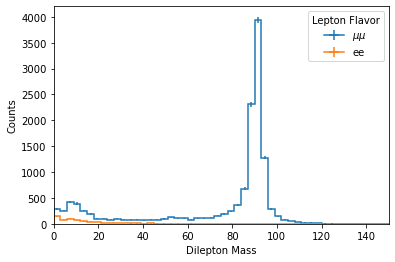

In [53]:
hist.plot1d(ll_hist)

In [55]:
sum(ll_hist.values()[('$\\mu\\mu$'),])

13274.0

## **Processors**

## Appendix

### Lookup Tables

### ServiceX

## Acknowledgements